In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../dataset/Wisconsin_365.csv')

## Feature Engineering

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute

# Create time-based features
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
# Assume you have a predefined list of holidays
holidays = pd.to_datetime(['2024-01-01', '2024-12-25'])  # Example holidays
df['Is_Holiday'] = df['Date'].apply(lambda x: 1 if x in holidays else 0)

# Lag features for key measurements
df['A_GH_ft_Lag1'] = df['A_GH_ft'].shift(1)
df['A_GHTW_ft_Lag1'] = df['A_GHTW_ft'].shift(1)
df['A1_D_SP_inches_Lag1'] = df['A1_D-SP_inches'].shift(1)
df['B1_D_SP_inches_Lag1'] = df['B1_D-SP_inches'].shift(1)
df['C_D_MGH_ft_Lag1'] = df['C_D-MGH_ft'].shift(1)

# Rolling statistics for key measurements
df['A_GH_ft_Rolling_Mean_3'] = df['A_GH_ft'].rolling(window=3).mean()
df['A_GH_ft_Rolling_Std_3'] = df['A_GH_ft'].rolling(window=3).std()
df['A_GHTW_ft_Rolling_Mean_3'] = df['A_GHTW_ft'].rolling(window=3).mean()
df['A_GHTW_ft_Rolling_Std_3'] = df['A_GHTW_ft'].rolling(window=3).std()

# Interaction features
df['A_GH_ft_A1_D_SP_inches_Interaction'] = df['A_GH_ft'] * df['A1_D-SP_inches']
df['A_GHTW_ft_B1_D_SP_inches_Interaction'] = df['A_GHTW_ft'] * df['B1_D-SP_inches']

# Drop rows with NaN values resulting from lag or rolling operations
df = df.dropna()

print(df.head())

        Date  A_GH_ft  A_GHTW_ft  A1_D-SP_inches  A2_D-SP_inches  \
2 2023-08-31      8.3        4.8             0.2             0.3   
3 2023-09-01      8.3        4.8             0.0             0.1   
4 2023-09-02      8.3        4.8             0.0             0.1   
5 2023-09-03      8.3        4.8             0.0             0.1   
6 2023-09-04      8.3        4.8             0.0             0.1   

   B1_D-SP_inches  B2_D-SP_inches  C_D-MGH_ft  D_D-MGH_ft  E_D-MGH_ft  ...  \
2             0.4             0.2        92.7        12.3         6.7  ...   
3             0.0             0.0        92.7        12.3         6.7  ...   
4             0.0             0.0        92.7        12.3         6.7  ...   
5             0.0             0.0        92.7        12.3         6.7  ...   
6             0.0             0.0        92.7        12.3         6.7  ...   

   A_GHTW_ft_Lag1  A1_D_SP_inches_Lag1  B1_D_SP_inches_Lag1  C_D_MGH_ft_Lag1  \
2             4.8                  0.2    

In [4]:
df = df.drop(columns=['Hour', 'Minute']).reset_index(drop=True)

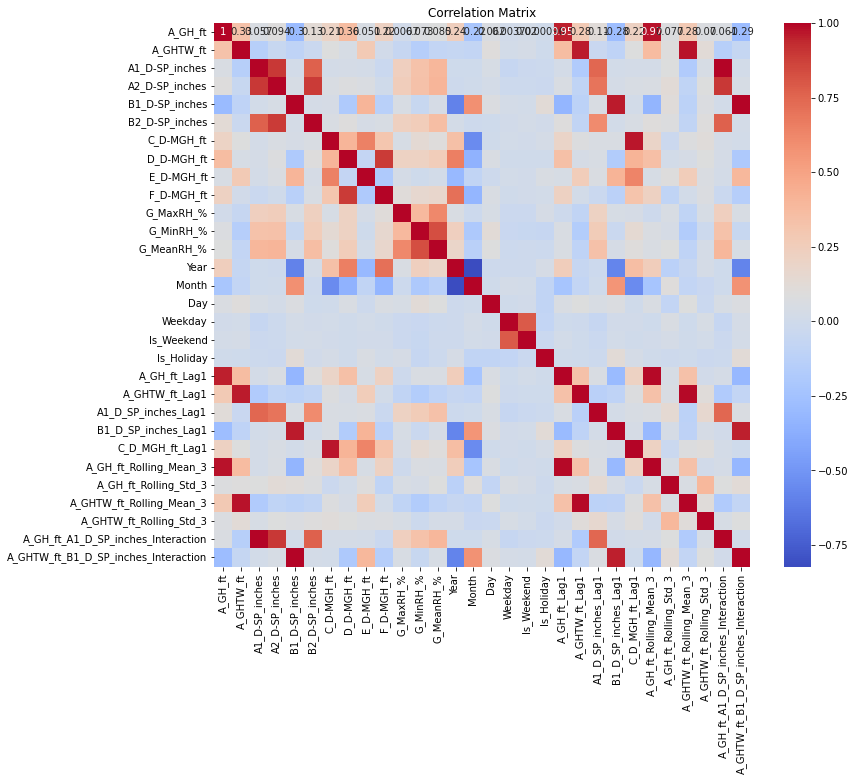

In [5]:
correlation_matrix = df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering result

### 1. New Features Created:
* Lagged Features: Captured past values (e.g., A_GH_ft_Lag1, A_GHTW_ft_Lag1).
* Rolling Statistics: Averaged and spread measures (e.g., A_GH_ft_Rolling_Mean_3, A_GH_ft_Rolling_Std_3).
* Interaction Terms: Combined features to capture non-linear relationships (e.g., A_GH_ft_A1_D_SP_inches_Interaction).
### 2. Correlation Analysis
#### High Correlations Observed:
* A_GH_ft and A_GH_ft_Lag1 (0.95): Strong temporal dependence.
* A_GHTW_ft and A_GHTW_ft_Lag1 (0.96): Consistent past influence.
* A1_D_SP_inches and A2_D_SP_inches (0.90): High similarity in dimensions.

#### Low or No Correlations:
* Is_Weekend and most features (near 0): Minimal impact on target variables.
* Hour and Minute (NA): Insufficient data for inclusion.
### 3. Key Findings
#### Significant Interactions:
* A_GH_ft_A1_D_SP_inches_Interaction and A_GHTW_ft_B1_D_SP_inches_Interaction show strong predictive potential.

#### Feature Stability:
* Rolling means and standard deviations provide stable indicators, useful for smoothing and trend analysis.

## Ensemble Model for Feature Selection

In [7]:
ndf = df.drop(columns=['Date']).reset_index(drop=True)

In [8]:
# Gage height is target as it is the level of basin depth

features = ndf.drop(columns=['A_GH_ft'])  
target = ndf['A_GH_ft'] 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00039246575342461647


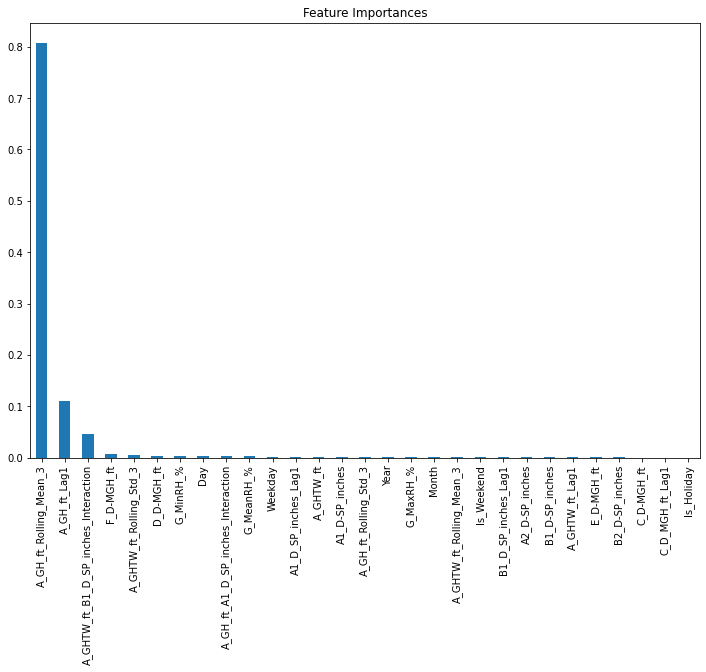

Important features based on Random Forest:
A_GH_ft_Rolling_Mean_3                  8.065774e-01
A_GH_ft_Lag1                            1.096720e-01
A_GHTW_ft_B1_D_SP_inches_Interaction    4.496233e-02
F_D-MGH_ft                              7.752102e-03
A_GHTW_ft_Rolling_Std_3                 4.713747e-03
D_D-MGH_ft                              2.601591e-03
G_MinRH_%                               2.494968e-03
Day                                     2.345528e-03
A_GH_ft_A1_D_SP_inches_Interaction      2.276036e-03
G_MeanRH_%                              2.158324e-03
Weekday                                 1.576557e-03
A1_D_SP_inches_Lag1                     1.480856e-03
A_GHTW_ft                               1.479689e-03
A1_D-SP_inches                          1.375046e-03
A_GH_ft_Rolling_Std_3                   1.356428e-03
Year                                    1.277143e-03
G_MaxRH_%                               1.097616e-03
Month                                   9.882134e-04
A_G

In [12]:
# Get feature importances
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

# Display important features
print("Important features based on Random Forest:")
print(feature_importances)

### Model Input Features

- A_GH_ft_Rolling_Mean_3   
    * Dependant:      df['A_GH_ft'].rolling(window=3).mean()          
- A_GH_ft_Lag1 
    * Dependant:      df['A_GH_ft'].shift(1)                           
- A_GHTW_ft_B1_D_SP_inches_Interaction    
    * Dependant:       df['A_GHTW_ft'] * df['B1_D-SP_inches']

## Threshold Calculation

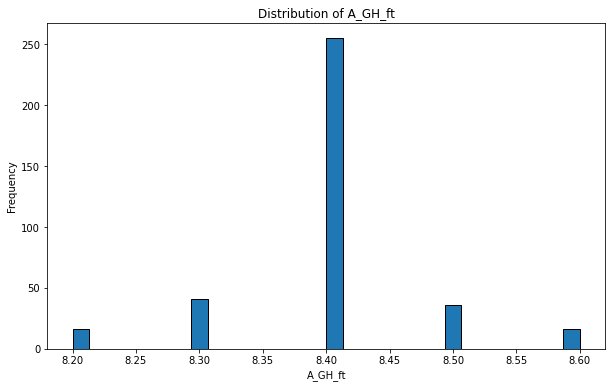

In [13]:
import matplotlib.pyplot as plt

# Plot histogram of A_GH_ft values
plt.figure(figsize=(10, 6))
plt.hist(ndf['A_GH_ft'], bins=30, edgecolor='k')
plt.title('Distribution of A_GH_ft')
plt.xlabel('A_GH_ft')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Calculate percentiles for thresholds
minThreshold = ndf['A_GH_ft'].quantile(0.05)  # 25th percentile
maxThreshold = ndf['A_GH_ft'].quantile(0.95)  # 75th percentile

print(f"minThreshold: {minThreshold}")
print(f"maxThreshold: {maxThreshold}")


minThreshold: 8.3
maxThreshold: 8.5


In [15]:
# Define flood severity based on thresholds
def classify_severity(value, minT, maxT):
    if value < minT:
        return 'Low'
    elif minT <= value < maxT:
        return 'Moderate'
    else:
        return 'High'

# Apply classification
ndf['Flood_Severity'] = ndf['A_GH_ft'].apply(lambda x: classify_severity(x, minThreshold, maxThreshold))

# Display the updated DataFrame
print(ndf[['A_GH_ft', 'Flood_Severity']])


     A_GH_ft Flood_Severity
0        8.3       Moderate
1        8.3       Moderate
2        8.3       Moderate
3        8.3       Moderate
4        8.3       Moderate
..       ...            ...
359      8.4       Moderate
360      8.4       Moderate
361      8.4       Moderate
362      8.4       Moderate
363      8.4       Moderate

[364 rows x 2 columns]


## Model
### Threshold based Alert Alogirthm(TBA) + RF Classifier

In [16]:
def calculate_features(A_GH_ft, A_GHTW_ft, B1_D_SP_inches, df):
    # Calculate rolling mean
    A_GH_ft_Rolling_Mean_3 = df['A_GH_ft'].rolling(window=3).mean().iloc[-1]

    # Calculate lag feature
    A_GH_ft_Lag1 = df['A_GH_ft'].shift(1).iloc[-1]

    # Calculate interaction term
    A_GHTW_ft_B1_D_SP_inches_Interaction = A_GHTW_ft * B1_D_SP_inches
    
    return A_GH_ft_Rolling_Mean_3, A_GH_ft_Lag1, A_GHTW_ft_B1_D_SP_inches_Interaction


In [17]:
from sklearn.metrics import accuracy_score

X = ndf[['A_GH_ft_Rolling_Mean_3', 'A_GH_ft_Lag1', 'A_GHTW_ft_B1_D_SP_inches_Interaction']]
y = ndf['Flood_Severity']

In [18]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
WisonsinModel = RandomForestClassifier(n_estimators=100, random_state=42)
WisonsinModel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
user_A_GH_ft = 8.5
user_A_GHTW_ft = 4.9
user_B1_D_SP_inches = 0.3

# Calculate features for prediction
rolling_mean, lag1, interaction = calculate_features(user_A_GH_ft, user_A_GHTW_ft, user_B1_D_SP_inches, ndf)

# Prepare input for prediction
input_features = pd.DataFrame([[rolling_mean, lag1, interaction]], columns=['A_GH_ft_Rolling_Mean_3', 'A_GH_ft_Lag1', 'A_GHTW_ft_B1_D_SP_inches_Interaction'])

# Predict flood severity
flood_severity = WisonsinModel.predict(input_features)
print(f"Predicted Flood Severity: {flood_severity[0]}")

Predicted Flood Severity: Moderate


In [21]:
import joblib

# joblib.dump(WisonsinModel, '../wisconsin_model.pkl')

['../wisconsin_model.pkl']